In [1]:
import os
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns

from nltk.tokenize.casual import EMOTICON_RE
from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.preprocess import remove_urls, strip_html
from reviews.config import processed_data_dir
from reviews.utils import clean_brand

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Cleaning

## Products

In [18]:
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   asin         32720 non-null  object
 1   brand        32720 non-null  object
 2   category     32720 non-null  object
 3   description  32720 non-null  object
 4   price        32720 non-null  object
 5   title        32720 non-null  object
dtypes: object(6)
memory usage: 1.5+ MB


In [19]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...",[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...",[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...",[APC 650 VA Uninterruptable Power Supply],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...",[Based on the award-winning Sound Blaster 16 t...,$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...",[Monster Sound MX300 is the new-generation PCI...,,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...",[Adding memory to your new or existing desktop...,,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [20]:
# keep the first subcategory and rename categories
prod_df["category"] = prod_df["category"].parallel_apply(
    lambda x: x[4] if len(x) > 4 else "other"
)
prod_df["category"] = prod_df["category"].apply(
    lambda cat: cat.replace("Internal", "").strip() if type(cat) is str else cat
)

# join description in a single string
prod_df["description"] = prod_df["description"].parallel_apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").parallel_apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").parallel_apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 20, "price"] = np.nan

prod_df["brand"] = prod_df["brand"].apply(clean_brand)

In [21]:
prod_df.head(10)

,asin,brand,category,description,price,title
0,7500653883,ecs elitegroup,Motherboards,NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,mygica,TV Tuner & Capture Cards,"Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,creative,Modems,NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,apc,Power Supplies,APC 650 VA Uninterruptable Power Supply,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,creative,Sound Cards,Based on the award-winning Sound Blaster 16 te...,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,diamond,Graphics Cards,Monster Sound MX300 is the new-generation PCI ...,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,sonicblue,Graphics Cards,"Based on the NVIDIA RIVA TNT Ultra chip set, D...",NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,pny,Memory,Adding memory to your new or existing desktop ...,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [22]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")

### Check missing or null values

In [23]:
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   asin         32720 non-null  string  
 1   brand        32612 non-null  category
 2   category     32719 non-null  category
 3   description  30405 non-null  string  
 4   price        15855 non-null  float64 
 5   title        32720 non-null  string  
dtypes: category(2), float64(1), string(3)
memory usage: 1.2 MB


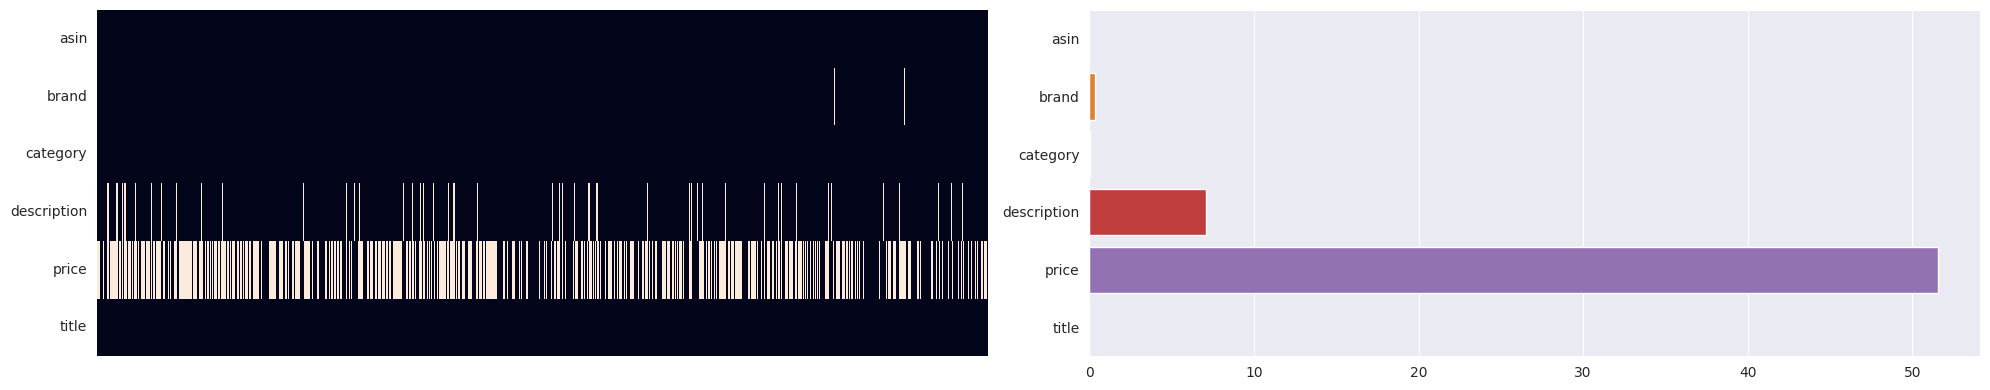

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(prod_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=prod_df.columns,
    x=(len(prod_df) - prod_df.count()) / len(prod_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

### Duplicates

In [25]:
# remove duplicates
prod_df.drop_duplicates(inplace=True)

## Reviews

In [26]:
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  object        
 1   overall    269027 non-null  int64         
 2   summary    269027 non-null  object        
 3   text       269027 non-null  object        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 12.3+ MB


In [27]:
review_df.head(10)

,asin,overall,summary,text,timestamp,vote
0,7799813393,3,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


In [28]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote"]:
    review_df[col] = review_df[col].astype("string").parallel_apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [29]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")

In [30]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269027 entries, 0 to 269026
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       269027 non-null  category      
 1   overall    269027 non-null  category      
 2   summary    269027 non-null  string        
 3   text       269025 non-null  string        
 4   timestamp  269027 non-null  datetime64[ns]
 5   vote       269027 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 9.3 MB


### Missing Values

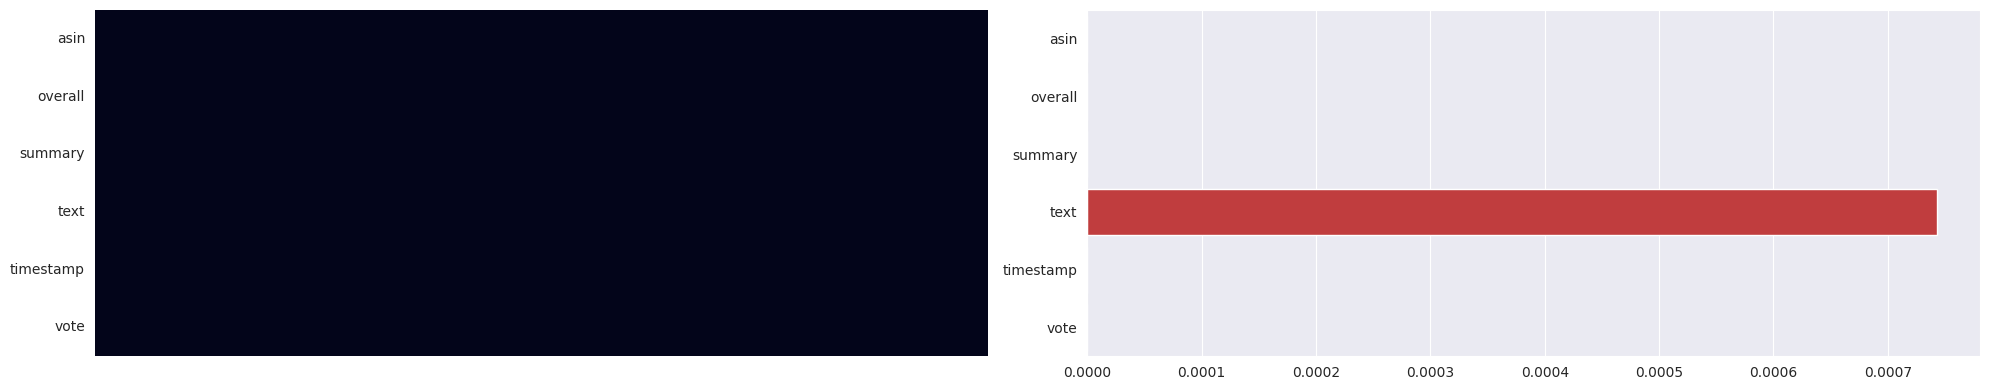

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(review_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=review_df.columns,
    x=(len(review_df) - review_df.count()) / len(review_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

In [32]:
# remove empty text
review_df = review_df.loc[~review_df["text"].isna()]

### Emojis

In [33]:
def find_emoji(t):
    return ", ".join(set(EMOTICON_RE.findall(t)))


review_df["emoji"] = review_df["text"].apply(find_emoji)

In [34]:
review_df["emoji"].value_counts()

                  258118
:)                  1870
d:                  1146
p:                   618
d;                   539
                   ...  
:(, D:                 1
>:|                    1
p8, :), :(, d:         1
8/, d:, P:             1
8P, =)                 1
Name: emoji, Length: 795, dtype: int64

In [35]:
emoji_list = []
for emojis in set(review_df[review_df["emoji"] != ""]["emoji"].tolist()):
    emoji_list.extend(emojis.split(", "))

emoji_list = set(emoji_list)
print(emoji_list)

review_df.drop(columns=["emoji"], inplace=True)

{':-]', '(-:', ':-)', ':@', '8}', 'po=', ':-|', '::', ';d', '(O8', '8{', ':-\\', 'po8', '}=', ';-)', 'D:', 'p-8', '8-p', 'Do;', ';D', '8(', '[=', '>8)', ';]', '={', '(*8', ':|', ':]', '(o;', '=d', ';P', '(O;', 'D;', ':8', 'D=', ']:', 'P-8', ':o(', '>:(', '/=', 'p=', ')-8', '8[', '|=', '/8', ':{', '=/', '\\8', 'd;', 'p8', 'P=', 'do;', '=[', '[8', '(:', 'p:', '=]', ':D', 'P8', ')8', '8:', ';(', ')=', '(8', ":'(", 'd=', '>:/', '(=', '=|', ']=', ';)', '/O:', ':\\', '=p', '@8', '8-D', '8-d', '=D', ':-(', ':d', 'd:', '8p', '):', 'p;', '<3', '<:-)', '=)', ':)', '];', '8/', ':/', 'do:', ':-P', ':=', ':-/', ');', '8-P', 'DO:', 'P;', ':-p', '(;', '};', '=od', '=P', ':O)', '=-)', ';o)', ':(', ';p', ':op', ':-D', '>:|', ';-(', ':[', '=\\', ':o)', '8)', ';-|', '=(', '/:', '\\=', '@:', '{8', '/;', ':p', '8D', ':}', '8@', ';/', '>;-(', '{:', ';[', 'D-8', ':P', "8')", 'D8', 'P:', "='D", '|:', ":')", "8'D", '8P', '8]', 'd-8', '8d', 'd8', '8\\'}


### Duplicates

In [36]:
# remove duplicates
review_df.drop_duplicates(inplace=True)

### Language Detection

In [37]:
if not os.path.exists("/tmp/lid.176.bin"):
    os.system(
        "wget -O /tmp/lid.176.bin 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'"
    )

In [ ]:
model = fasttext.load_model("/tmp/lid.176.bin")

langs = []
for i, row in review_df.iterrows():
    text = row["summary"] + ". " + row["text"].replace("\n", " ")

    text = remove_urls(text)
    text = strip_html(text)

    text = text.lower()

    lang = model.predict(text, threshold=0.95)

    if len(lang[0]) > 0:
        lang = lang[0][0].replace("__label__", "")

        if lang != "en":
            lang = "unknown"

        langs.append(lang)
    else:
        langs.append("unknown")

review_df["lang"] = langs

In [39]:
review_df["lang"].value_counts()

en         183856
unknown     85169
Name: lang, dtype: int64

In [40]:
# keep only english reviews
review_df = review_df.loc[review_df["lang"] == "en"]
review_df.drop(columns=["lang"], axis=1, inplace=True)

In [41]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183856 entries, 1 to 269025
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   asin       183856 non-null  category      
 1   overall    183856 non-null  category      
 2   summary    183856 non-null  string        
 3   text       183856 non-null  string        
 4   timestamp  183856 non-null  datetime64[ns]
 5   vote       183856 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(2)
memory usage: 7.8 MB


### Merge with Products

In [100]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)

data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

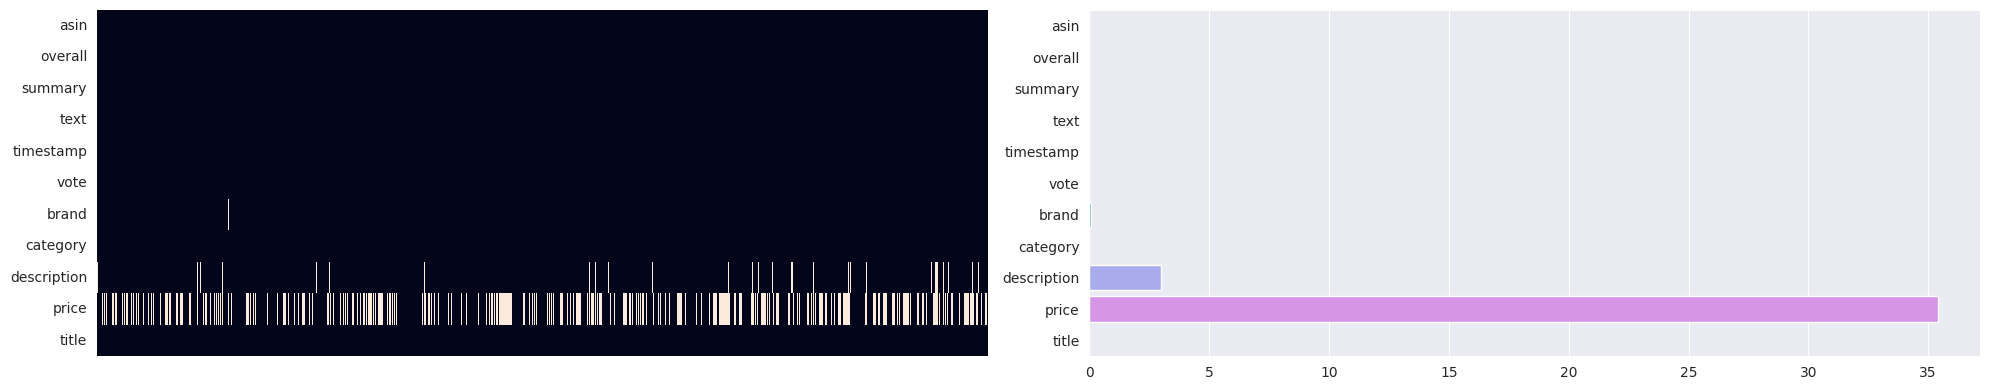

In [101]:
fig, axes = plt.subplots(1, 2, figsize=(20, 4))
sns.heatmap(data_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=data_df.columns,
    x=(len(data_df) - data_df.count()) / len(data_df) * 100,
    ax=axes[1],
)
fig.tight_layout()

In [102]:
data_df.drop(columns=["price"], inplace=True)

data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)

#### Sample Categories

In [103]:
# remove categories
remove_list = {"Memory Card Readers", "Modems"}
data_df.drop(data_df[data_df["category"].isin(remove_list)].index, inplace=True)

# update categories
data_df["category"] = data_df["category"].astype("string").astype("category")

In [104]:
# products per category
data_df.groupby("category")["asin"].nunique()

category
CPU Processors               370
Fans & Cooling              1251
Graphics Cards              1022
I/O Port Cards               298
Memory                      1351
Motherboards                 792
Network Cards                160
Optical Drives               229
Power Supplies               539
Sound Cards                   95
TV Tuner & Capture Cards     102
Name: asin, dtype: int64

In [105]:
# sample categories to reduce data

categories_to_sample = [
    cat for cat, count in data_df["category"].value_counts().items() if count > 5000
]

sample_df = data_df[data_df["category"].isin(categories_to_sample)].copy()
sample_df["category"] = sample_df["category"].astype("string").astype("category")

sample_df = sample_df.groupby("category").sample(5000, replace=False, random_state=42)

others_df = data_df[~data_df["category"].isin(categories_to_sample)].copy()
data_df = pd.concat((sample_df, others_df))

In [106]:
data_df["category"].value_counts()

CPU Processors              5000
Fans & Cooling              5000
Graphics Cards              5000
I/O Port Cards              5000
Memory                      5000
Motherboards                5000
Network Cards               5000
Optical Drives              5000
Power Supplies              5000
TV Tuner & Capture Cards    5000
Sound Cards                 3193
Name: category, dtype: Int64

#### Save

In [107]:
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

data_df.dropna(inplace=True)
data_df.drop_duplicates(inplace=True)
data_df.reset_index(drop=True, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53193 entries, 0 to 53192
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   asin         53193 non-null  category      
 1   overall      53193 non-null  category      
 2   summary      53193 non-null  string        
 3   text         53193 non-null  string        
 4   timestamp    53193 non-null  datetime64[ns]
 5   vote         53193 non-null  int64         
 6   brand        53193 non-null  category      
 7   category     53193 non-null  category      
 8   description  53193 non-null  string        
 9   title        53193 non-null  string        
dtypes: category(4), datetime64[ns](1), int64(1), string(4)
memory usage: 2.9 MB


In [109]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")